## Общий анализ имеющихся данных

В данном файле представлен первичный анализ данных, полученных из json файла. Само обучение в дальнейшем будет проводиться с помошью файлов .xml, поэтому в этом ноутбуке решил поработать именно с json интерпритацией для разнообразия.

#### Ключевое различие между xml и json разметкой боксов:
В __json__ каждый бокс имеет следующие 4 значения:<br>
_x_min, y_min, width, hight_ <br><br>
В __xml__ каждый бокс имеет следующие 4 значения:<br>
_x_min, y_min, x_max, y_max_

In [18]:
import pandas as pd
import numpy as np
import os
import random
import json
import cv2
from matplotlib.patches import Rectangle
from  matplotlib import pyplot as plt
%matplotlib inline

In [19]:
pwd = os.getcwd()
list_folders = os.listdir('detect_dataset')
print('Число фотографий в имеющемся датасете:',
      len(os.listdir('detect_dataset/images')))

Число фотографий в имеющемся датасете: 500


Раскроем json файл с размеченными bounding boxes:

In [5]:
path_json = 'detect_dataset/annotations/COCO_json/coco_annotations_train.json'

with open(path_json) as train_file:
    dict_train = json.load(train_file)

train_images_info = pd.DataFrame.from_dict(dict_train['images'])

Посмотрим, как выглядят данные в таблице с информацией о фотографиях:

In [6]:
train_images_info.head()

,id,width,height,file_name,license,flickr_url,coco_url,date_captured
0,1,1920,1080,oz_frame548.jpg,0,,,0
1,2,1920,1080,oz_frame547.jpg,0,,,0
2,3,1920,1080,oz_frame546.jpg,0,,,0
3,4,1920,1080,oz_frame538.jpg,0,,,0
4,5,1920,1080,oz_frame537.jpg,0,,,0


Определим какие есть уникальные значения высоты и ширины изображений в датасете:

In [7]:
print('ширина:', train_images_info.width.unique())
print('высота', train_images_info.height.unique())

ширина: [1920]
высота [1080]


Таким образом, все 500 фотографий в датасете имеют одинаковые размеры 1920:1080

Переименуем столбец id в image_id и оставим лишь столбец file_name помимо него

In [8]:
train_images_info = train_images_info.rename(columns={'id': 'image_id'})
train_images_info = train_images_info[['image_id', 'file_name']]
print(train_images_info.head())

   image_id        file_name
0         1  oz_frame548.jpg
1         2  oz_frame547.jpg
2         3  oz_frame546.jpg
3         4  oz_frame538.jpg
4         5  oz_frame537.jpg


Посмотрим на то, как выглядят данные по bounding боксам:

In [9]:
train_annotations_info = pd.DataFrame.from_dict(dict_train['annotations'])
train_annotations_info.head()

,id,image_id,category_id,segmentation,area,bbox,iscrowd,attributes
0,1,1,1,[],9660.2286,"[838.78, 268.37, 59.62, 162.03]",0,{'occluded': False}
1,2,1,1,[],3926.2467,"[841.61, 244.27, 62.49, 62.83]",0,{'occluded': False}
2,3,2,1,[],5005.3252,"[879.56, 243.42, 47.14, 106.18]",0,{'occluded': False}
3,4,2,1,[],9034.6585,"[841.61, 266.95, 53.89, 167.65]",0,{'occluded': False}
4,5,3,1,[],11517.0484,"[838.78, 265.53, 68.12, 169.07]",0,{'occluded': False}


Cделаем inner join этих двух таблиц по ключу image_id

In [10]:
df_data = pd.merge(train_images_info, train_annotations_info, on='image_id')\
    [['image_id', 'file_name', 'category_id', 'bbox']]
df_data

,image_id,file_name,category_id,bbox
0,1,oz_frame548.jpg,1,"[838.78, 268.37, 59.62, 162.03]"
1,1,oz_frame548.jpg,1,"[841.61, 244.27, 62.49, 62.83]"
2,2,oz_frame547.jpg,1,"[879.56, 243.42, 47.14, 106.18]"
3,2,oz_frame547.jpg,1,"[841.61, 266.95, 53.89, 167.65]"
4,3,oz_frame546.jpg,1,"[838.78, 265.53, 68.12, 169.07]"
...,...,...,...,...
910,496,am3_1_frame021.jpg,1,"[787.94, 401.03, 169.31, 438.42]"
911,497,am3_1_frame015.jpg,1,"[789.72, 417.07, 158.62, 470.49]"
912,498,am3_1_frame007.jpg,1,"[779.03, 458.06, 201.39, 522.18]"
913,499,am3_1_frame006.jpg,1,"[759.43, 470.54, 201.38, 536.43]"


In [11]:
df_data.category_id.value_counts()

category_id
1    915
Name: count, dtype: int64

Таким образом, имеется лишь один класс размеченный - это человек <br>
Определим сколько боксов на каждой фотографии

In [12]:
df_amount_objects = df_data.groupby('file_name', as_index=False).agg({'bbox':'count'})\
    .rename(columns={'bbox':'amount_objects'})
df_amount_objects.head()

,file_name,amount_objects
0,am3_1_frame004.jpg,1
1,am3_1_frame006.jpg,1
2,am3_1_frame007.jpg,1
3,am3_1_frame015.jpg,1
4,am3_1_frame021.jpg,1


Число объектов на фотографиях:

In [13]:
df_amount_objects.amount_objects.value_counts()

amount_objects
2    357
1    114
3     29
Name: count, dtype: int64

Сделаем представление информации о боксах для фотографий как массив массивов:

In [14]:
def func(data):
    return list(data)


df_box_info = df_data.groupby('file_name', as_index=False).agg({'bbox': func})
df_box_info

,file_name,bbox
0,am3_1_frame004.jpg,"[[747.38, 507.21, 235.25, 572.79]]"
1,am3_1_frame006.jpg,"[[759.43, 470.54, 201.38, 536.43]]"
2,am3_1_frame007.jpg,"[[779.03, 458.06, 201.39, 522.18]]"
3,am3_1_frame015.jpg,"[[789.72, 417.07, 158.62, 470.49]]"
4,am3_1_frame021.jpg,"[[787.94, 401.03, 169.31, 438.42]]"
...,...,...
495,oz_violation_frame545.jpg,"[[947.92, 237.2, 90.78, 179.0], [840.2, 262.7,..."
496,oz_violation_frame560.jpg,"[[860.0, 274.76, 81.6, 244.54], [970.5, 290.5,..."
497,oz_violation_frame561.jpg,"[[870.12, 282.28, 79.58, 235.92], [1001.77, 28..."
498,oz_violation_frame562.jpg,"[[998.94, 292.46, 65.26, 203.14], [885.25, 278..."


In [15]:
# Переведем это в словарь с ключом в виде имени файла и значением в виде массива массивов из боксов
dict_box_info = dict(zip(list(df_box_info.file_name), list(df_box_info.bbox)))

# загрузка изображений в словарь (ключ - имя файла)
img_dict = {}
for file in df_data['file_name'].unique():
    img = cv2.imread(f'detect_dataset/images/{file}')
    img_dict[file] = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

Отобразим случайные 3 фотки с боксами из имеющегося датасета:

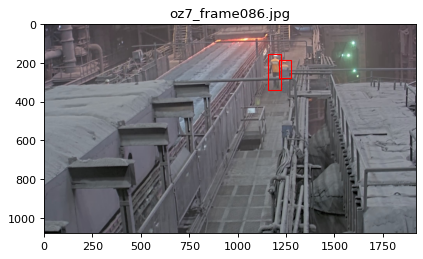

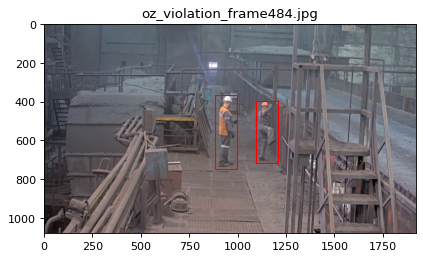

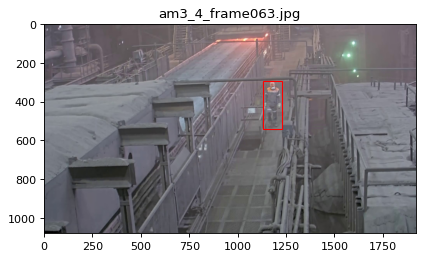

In [16]:
# Реализация с помощью matplotlib
random_img = random.sample(list(img_dict.keys()), 3)
for file_name in random_img:
    image = img_dict[file_name]
    boxes = dict_box_info[file_name]
    plt.figure(figsize=(6, 4), dpi=80)
    plt.imshow(image)
    plt.title(f'{file_name}')
    for box in boxes:
        x, y, w, h = map(int, box)
        plt.gca().add_patch(Rectangle((x,y), w, h,
            edgecolor='red',
            facecolor='none',
            lw= 1 )) 
    plt.show()     

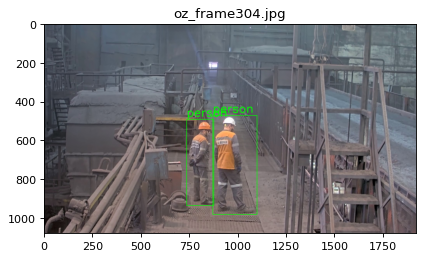

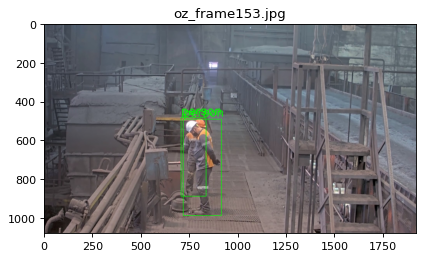

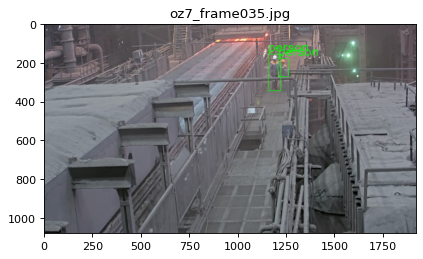

In [17]:
# Реализация с помощью cv2
random_img = random.sample(list(img_dict.keys()), 3)
for file_name in random_img:
    image = img_dict[file_name]
    boxes = dict_box_info[file_name]
    plt.figure(figsize=(6, 4), dpi=80)
    plt.title(f'{file_name}')
    class_name = 'person'
    for box in boxes:
        x, y, w, h = map(int, box)
        image = cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
        image = cv2.putText(image, class_name, (x, y - 15), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 255, 0), 3)
    plt.imshow(image)
    plt.show()

В данном ноутбуке я показал как можно проанализировать данные о форографии, распарсив json файл с аннотациями боксов